# Image classification Baseline Model

This tutorial indicates the a baseline model for classification of Salmonella, Coccidiosis poultry diseases and the healthy class. 

It uses the Keras Library. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. 

The code covers the following concepts and a basic ML workflow:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.


Acknowledgment: Google, [Image Classification](https://www.tensorflow.org/tutorials/images/classification)

## Import TensorFlow and other libraries

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

This tutorial uses a [dataset](http://doi.org/10.5281/zenodo.4628934) of about 1,500 images of chicken droppings. 

The dataset contains 3 sub-directories, one per class:

```
poultryFecal_images/
  cocci/
  healthy/
  salmo/
  ```

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



In [2]:
data_dir = '/content/gdrive/MyDrive/poultryFecal_images'

# Load using keras.preprocessing

.

Define some parameters for the loader:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

The dataset split is 80% for training, and 20% of the images for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


The `class_names` attribute on these datasets. 

In [8]:
class_names = train_ds.class_names
print(class_names)

['cocci', 'healthy', 'salmo']


## Visualize the data

Here are the first 9 images from the training dataset.

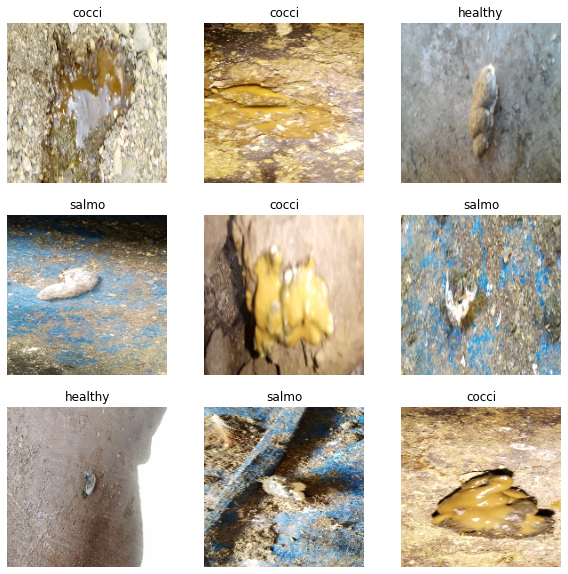

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Manually iterating over the dataset and retrieve batches of images:

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

This is included on the layer inside the model definition 

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. 

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. 

In [12]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [15]:
epochs=8
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/8
38/38 [==============================] - 1743s 12s/step - loss: 1.0228 - accuracy: 0.4569 - val_loss: 0.4458 - val_accuracy: 0.8400
Epoch 2/8
38/38 [==============================] - 1s 14ms/step - loss: 0.4185 - accuracy: 0.8386 - val_loss: 0.2790 - val_accuracy: 0.8933
Epoch 3/8
38/38 [==============================] - 1s 14ms/step - loss: 0.2806 - accuracy: 0.8895 - val_loss: 0.3159 - val_accuracy: 0.8767
Epoch 4/8
38/38 [==============================] - 1s 14ms/step - loss: 0.2504 - accuracy: 0.9117 - val_loss: 0.2274 - val_accuracy: 0.9167
Epoch 5/8
38/38 [==============================] - 1s 14ms/step - loss: 0.2384 - accuracy: 0.9061 - val_loss: 0.1874 - val_accuracy: 0.9367
Epoch 6/8
38/38 [==============================] - 1s 14ms/step - loss: 0.1794 - accuracy: 0.9430 - val_loss: 0.2294 - val_accuracy: 0.9300
Epoch 7/8
38/38 [==============================] - 1s 14ms/step - loss: 0.1452 - accuracy: 0.9497 - val_loss: 0.1928 - val_accuracy: 0.9367
Epoch 8/8
38/38 [=

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

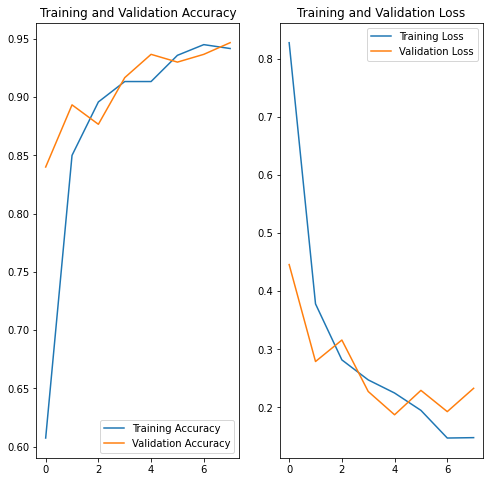

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are aligned and the model has achieved around 85% accuracy on the validation set.

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [41]:
healthy_path = '/content/gdrive/MyDrive/data_APDD/imgAll/test/healthy/healthy.42.jpg'
img = keras.preprocessing.image.load_img(
    healthy_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to healthy with a 64.34 percent confidence.
